# Bernoulli STM implementation

## Loading libraries

In [1]:
# Load libraries
import logging
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.ops.indexing import Vindex

import torch
from torch.distributions import constraints

import numpy as np
import pandas as pd

from zzz_utils_plot import *
from stm_cell_bern import *

import matplotlib.pyplot as plt

logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)

pyro.clear_param_store()
pyro.set_rng_seed(1234)

## Simulate

In [2]:
##### Simulation strategy
nCells = 500
nRegions = 800
nTopics = 2
nCovX = 1

# Covariates
X1 = torch.ones(nCells).reshape(nCells, 1)
X2 = dist.Normal(0, 0.3).sample([nCells]).reshape(nCells, 1) + torch.arange(nCells).reshape(nCells, 1)/150 - 2
#X2 = scale_zero_one(X2)
X = X2
# Coefficients
gamma = torch.tensor([[2.5]])

#gamma = torch.tensor([[2, 0], [-0.5, 2]])
alpha = torch.matmul(X, gamma)
# Cell topics distribution
theta = dist.LogisticNormal(alpha, 0.1).sample()

In [3]:
gamma

tensor([[2.5000]])

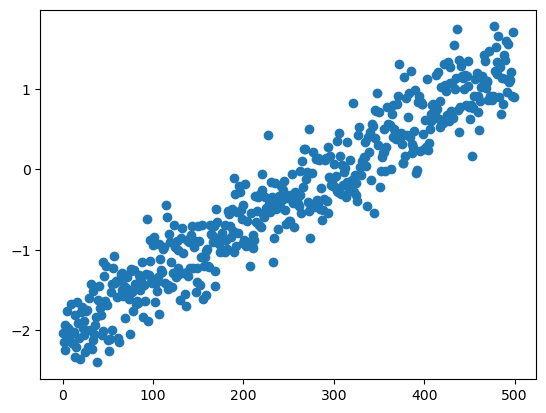

In [4]:
plt.scatter(x=torch.arange(nCells), y=X2.squeeze(-1))
plt.show()

In [5]:
# Detection rate (coverage)
cov = dist.Beta(5, 2).sample([nRegions])# + 0.02
# Topics region distribution
phi = LogitNormal(-2, 4).sample([nRegions, nTopics])
# Index matrix on nRegions x nCells
idx = torch.arange(0,nRegions).unsqueeze(1).repeat(1, nCells)
with pyro.plate(name='nCells', size=nCells):
    with pyro.plate(name='nRegions', size=nRegions): 
        z = pyro.sample(name='z', fn=dist.Categorical(theta))
        phi_z = Vindex(phi)[..., idx, z]
        phi_z = (phi_z.T * cov).T
        D = pyro.sample(name='w', fn=dist.Bernoulli(phi_z))
pyro.clear_param_store()
# Numpy array for PCA
D_np = D.detach().numpy().transpose()

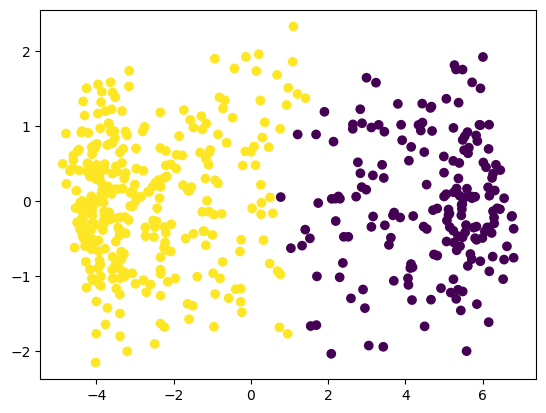

In [6]:
label = theta.detach().numpy()
from sklearn.decomposition import PCA
pca = PCA()
Xt = pca.fit_transform(D_np)
plot = plt.scatter(Xt[:,0], Xt[:,1], c = label.argmax(axis=1).tolist())
#plt.legend(handles=plot.legend_elements()[0], labels=list(winedata['target_names']))
plt.show()

In [33]:
theta[1:10, :]

tensor([[0.0041, 0.9959],
        [0.0077, 0.9923],
        [0.0044, 0.9956],
        [0.0074, 0.9926],
        [0.0117, 0.9883],
        [0.0067, 0.9933],
        [0.0053, 0.9947],
        [0.0063, 0.9937],
        [0.0147, 0.9853]])

In [34]:
theta[350:370, :]

tensor([[0.8708, 0.1292],
        [0.3387, 0.6613],
        [0.4814, 0.5186],
        [0.5770, 0.4230],
        [0.6656, 0.3344],
        [0.6156, 0.3844],
        [0.8038, 0.1962],
        [0.5765, 0.4235],
        [0.6776, 0.3224],
        [0.8768, 0.1232],
        [0.8161, 0.1839],
        [0.8109, 0.1891],
        [0.7686, 0.2314],
        [0.4816, 0.5184],
        [0.8573, 0.1427],
        [0.7183, 0.2817],
        [0.8741, 0.1259],
        [0.7523, 0.2477],
        [0.7260, 0.2740],
        [0.7286, 0.2714]])

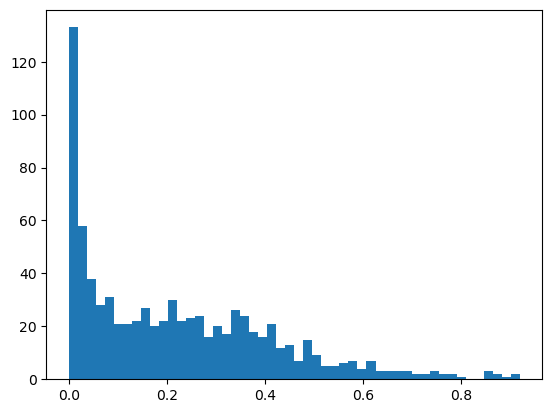

In [7]:
plt.hist(D.mean(axis=1), bins=50)
plt.show()

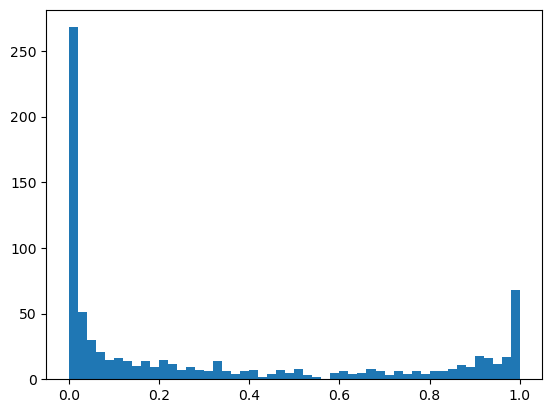

In [37]:
plt.hist(phi[:, 0], bins=50)
plt.show()

In [9]:
#pyro.set_rng_seed(123)
#trace = pyro.poutine.trace(tm_bern_model).get_trace()
#trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
#print(trace.format_shapes())

## Bernoulli topic model

Below we define the STM model with Pyro. Note that data D is a matrix of __nRegions x nCells__.

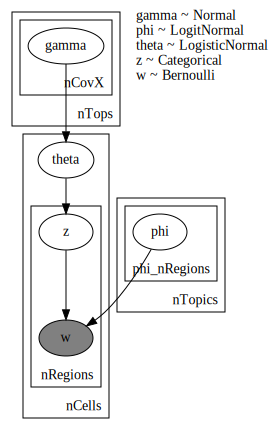

In [10]:
pyro.clear_param_store()
pyro.render_model(stm_cell_bern_model, model_args=(D, nTopics, X), 
                  render_distributions=True, render_params=True)

## LDA guide (variational approximation)

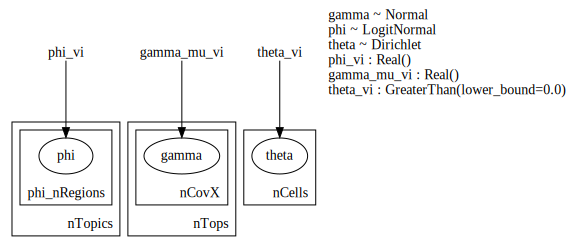

In [11]:
pyro.clear_param_store()
pyro.render_model(stm_cell_bern_guide, model_args=(D, nTopics, X), 
                  render_distributions=True, render_params=True)

# Testing variational inference

In [12]:
# Filter to keep only regions with decent coverage
det_thr = 0.1

qc_peak_idx = np.where(np.array(D.mean(axis=1)) > det_thr)[0]
print('Number of peak regions passing QC threshold:', len(qc_peak_idx))
D_filt = D[qc_peak_idx, :]
print(D_filt.shape)

Number of peak regions passing QC threshold: 501
torch.Size([501, 500])


## Fit LDA 

To perform inference for TM Bernoulli with use ClippedAdam to optimize a 
__trace implementation of ELBO-based SVI__ ('TraceEnum_ELBO'), which supports exhaustive enumeration 
over discrete sample sites, in our case latent topic assignment __z__.

In [13]:
#nTopics = 2
nSteps = 1000
lr = 0.1
seed = 123

pyro.set_rng_seed(seed)
pyro.clear_param_store()

# We'll fit using SVI.
logging.info("-" * 40)
logging.info("Fitting {} cells".format(D.shape[1]))

elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=2)
optim = pyro.optim.Adam({"lr": lr, 'weight_decay':0.01})
svi = pyro.infer.SVI(stm_cell_bern_model, stm_cell_bern_guide, optim, elbo)
losses = []

logging.info("Step\tLoss")
for step in range(nSteps):
    loss = svi.step(D=D_filt, nTopics=nTopics, X=X)
    if step % 100 == 0:
        logging.info("{: >5d}\t{}".format(step, loss))
    losses.append(loss)
logging.info("final loss = {}".format(loss))

     7633 ----------------------------------------
     7634 Fitting 500 cells
     7635 Step	Loss
     7696     0	183748.046875
    11013   100	129283.2734375
    14412   200	127968.2734375
    17792   300	127704.6640625
    21633   400	127767.0
    25458   500	127472.71875
    29074   600	127457.7734375
    32908   700	127411.71875
    36737   800	127395.4140625
    40544   900	127385.859375
    44081 final loss = 127340.515625


Here we plot the elbo loss during optimisation

Text(0, 0.5, 'ELBO loss')

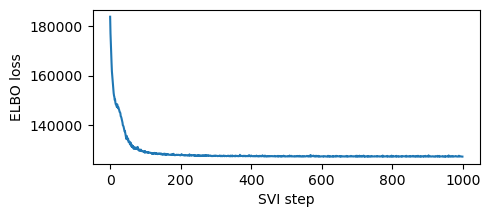

In [14]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

## Assessing inferred parameters

Below we show estimates of the inferred model parameters. To show this, here I am just taking a sample from the 
posterior fit (i.e. calling the guide with the optimized set of variational parameters). Surely this is not the optimal way to summarise the posterior fit. 

__However__, if I take multiple samples from the posterior and subseqently summarise the posterior samples (e.g. by median), due to label switching that occurs when sampling 
$\theta \sim Dir(\alpha)$, the posterior mode will be useless. 

__TODO__ 

1. Define a better way to summarize the posterior distribution from posterior samples. E.g. by fixing the label switching problem, post-hoc after sampling from the posterior (similar approach to mixture models).
2. Make posterior predictive checks.
3. Need to understand Pyro's `poutine`.


In [15]:
#for name, value in pyro.get_param_store().items():
#    print(name, pyro.param(name).data.cpu().numpy())

In [16]:
pyro.param("gamma_mu_vi").detach()

tensor([[3.2957]])

In [17]:
pyro.param("theta_vi").detach()[1:10, :]

tensor([[3.9863e+00, 3.3336e+03],
        [4.0351e+00, 1.9078e+03],
        [3.7851e+00, 4.6910e+03],
        [3.2524e+00, 1.6647e+03],
        [3.5048e+00, 1.0612e+03],
        [4.0040e+00, 1.8608e+03],
        [3.1699e+00, 2.1215e+03],
        [4.0947e+00, 2.3835e+03],
        [3.2420e+00, 5.4217e+02]])

In [18]:
# A single sample from the guide
post_sample = stm_cell_bern_guide(D = D_filt, nTopics = nTopics, X = X)

In [19]:
theta[1:10, ] # first 10 cells prob assignments to each topic

tensor([[0.0041, 0.9959],
        [0.0077, 0.9923],
        [0.0044, 0.9956],
        [0.0074, 0.9926],
        [0.0117, 0.9883],
        [0.0067, 0.9933],
        [0.0053, 0.9947],
        [0.0063, 0.9937],
        [0.0147, 0.9853]])

In [20]:
post_sample['theta'][1:10, :] # posterior theta

tensor([[0.0011, 0.9989],
        [0.0017, 0.9983],
        [0.0017, 0.9983],
        [0.0016, 0.9984],
        [0.0032, 0.9968],
        [0.0023, 0.9977],
        [0.0012, 0.9988],
        [0.0015, 0.9985],
        [0.0090, 0.9910]], grad_fn=<SliceBackward0>)

In [21]:
post_sample['theta'][350:360, :] # posterior theta

tensor([[0.8369, 0.1631],
        [0.3393, 0.6607],
        [0.5663, 0.4337],
        [0.6273, 0.3727],
        [0.6234, 0.3766],
        [0.5832, 0.4168],
        [0.8771, 0.1229],
        [0.5693, 0.4307],
        [0.7141, 0.2859],
        [0.9037, 0.0963]], grad_fn=<SliceBackward0>)

In [22]:
post_sample['phi'][1:10, :].detach().numpy() # posterior phi

array([[0.12338603, 0.46949962],
       [0.7143729 , 0.48286462],
       [0.12084696, 0.6775484 ],
       [0.19788697, 0.06272591],
       [0.15275168, 0.5136871 ],
       [0.60917246, 0.17942071],
       [0.36005005, 0.03316199],
       [0.8239255 , 0.35104066],
       [0.2503442 , 0.9496287 ]], dtype=float32)

In [23]:
phi[1:10, :]

tensor([[0.5969, 0.9919],
        [0.9935, 0.8052],
        [0.1569, 0.9325],
        [0.2506, 0.1244],
        [0.0090, 0.0073],
        [0.1072, 0.0295],
        [0.2218, 0.7848],
        [0.8270, 0.1272],
        [0.4124, 0.0272]])

### Topic-cell distribution plots

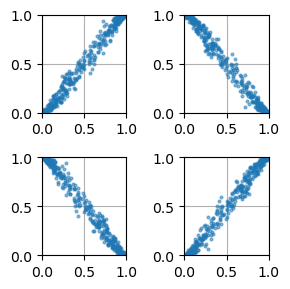

In [24]:
f = make_theta_comparison_plots(theta_true = theta, 
                                theta_infer = post_sample['theta'].detach().numpy())

### Topic-region distribution plots

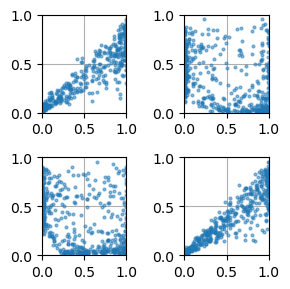

In [25]:
f = make_theta_comparison_plots(theta_true = phi[qc_peak_idx, :], 
                                theta_infer = post_sample['phi'].detach().numpy())